The goal of this notebook is to organize the process of doing a regression analysis. The steps I see for the process are the following:  
1) Data exploration and preparation  
2) Choosing the model type  
3) Testing the model  
4) Choosing the model  

I'm going to test this with the 2015 NYC Citibike data for NYC. I will try to predict the number of daily users with the info in the Citibike data and historical weather data from wunderground.com.

## Part I: Data Exploration and Preparation

In [2]:
#Import some of the tools I know I will need:
import numpy as np
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Python 2 & 3 Compatibility
from __future__ import print_function, division

%matplotlib inline

Make a list of all the files for the year 2015:

In [3]:
file_num = ["%.2d" % (i+1) for i in range(12)]


Open them as pandas dataframes and append them to a list:

In [162]:
data_2015 = []
for number in file_num:
    zip_file = 'https://s3.amazonaws.com/tripdata/2015'+ number + '-citibike-tripdata.zip'
    print(zip_file)
    r = requests.get(zip_file)
    with zipfile.ZipFile(io.BytesIO(r.content)) as ar:
        csv_file = '2015' + number + '-citibike-tripdata.csv'
        data_2015.append(pd.read_csv(ar.open(csv_file)))

https://s3.amazonaws.com/tripdata/201501-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201502-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201503-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201504-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201505-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201506-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201507-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201508-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201509-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201510-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201511-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201512-citibike-tripdata.zip


Check which months have a different datetime format:

In [165]:
i=1
for df in data_2015:
    print( "month =", i)
    print( "starttime", df['starttime'][1])
    print( "stoptime", df['stoptime'][1])
    print ("shape", df.shape)
    i=i+1

month = 1
starttime 1/1/2015 0:02
stoptime 1/1/2015 0:08
shape (285552, 15)
month = 2
starttime 2/1/2015 0:00
stoptime 2/1/2015 0:07
shape (196930, 15)
month = 3
starttime 3/1/2015 0:01
stoptime 3/1/2015 0:14
shape (341826, 15)
month = 4
starttime 4/1/2015 00:00:52
stoptime 4/1/2015 00:10:31
shape (652390, 15)
month = 5
starttime 5/1/2015 00:00:28
stoptime 5/1/2015 00:25:52
shape (961986, 15)
month = 6
starttime 6/1/2015 0:00
stoptime 6/1/2015 0:05
shape (941219, 15)
month = 7
starttime 7/1/2015 00:00:06
stoptime 7/1/2015 00:05:29
shape (1085676, 15)
month = 8
starttime 8/1/2015 00:00:05
stoptime 8/1/2015 00:05:06
shape (1179044, 15)
month = 9
starttime 9/1/2015 00:00:00
stoptime 9/1/2015 00:02:45
shape (1289699, 15)
month = 10
starttime 10/1/2015 00:00:02
stoptime 10/1/2015 00:09:55
shape (1212277, 15)
month = 11
starttime 11/1/2015 00:00:01
stoptime 11/1/2015 00:18:15
shape (987245, 15)
month = 12
starttime 12/1/2015 07:38:15
stoptime 12/1/2015 07:49:39
shape (804125, 15)


Months 4,5,7,8,9,10,11,12 have a different date time format. Will need to convert all to datetime format seperately.

In [167]:
month = 0
for df in data_2015:
    month = month+1
    other_format = [4,5,7,8,9,10,11,12]
    if month in other_format:
        print(month)
        df['starttime'] = pd.to_datetime(df['starttime'], format = '%m/%d/%Y %H:%M:%S')
        df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%m/%d/%Y %H:%M:%S')
    else:
        print(month)
        df['starttime'] = pd.to_datetime(df['starttime'], format = '%m/%d/%Y %H:%M')
        df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%m/%d/%Y %H:%M')

1
2
3
4
5
6
7
8
9
10
11
12


Combine dataframes into one dataframe

In [168]:
trip_data = pd.concat(data_2015)

Pickle the dataframe so I dont have to load it again:

In [169]:
trip_data.to_pickle("raw_citibike_data.pkl")

Read in pickled df if needed:

In [4]:
trip_data = pd.read_pickle("raw_citibike_data.pkl")

In [5]:
trip_data = trip_data.reset_index()
trip_data = trip_data.drop('index', axis = 1)

In [6]:
trip_data.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,2015-01-01 00:01:00,2015-01-01 00:24:00,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,2015-01-01 00:02:00,2015-01-01 00:08:00,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1


In [7]:
print("There are",trip_data.shape[0],"trips logged in this dataset")

There are 9937969 trips logged in this dataset


Check for nulls:

In [8]:
trip_data.isnull().sum()

tripduration                     0
starttime                        0
stoptime                         0
start station id                 0
start station name               0
start station latitude           0
start station longitude          0
end station id                   0
end station name                 0
end station latitude             0
end station longitude            0
bikeid                           0
usertype                         0
birth year                 1311378
gender                           0
dtype: int64

Looks like only birth_year is missing data.

Check data types:

In [9]:
trip_data.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

In [10]:
trip_data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,9.937969e+06,8.626591e+06,9.937969e+06
mean,9.680877e+02,6.181264e+02,4.073592e+01,-7.398947e+01,6.105992e+02,4.073563e+01,-7.398963e+01,1.945289e+04,1.976553e+03,1.068916e+00
std,7.609485e+03,7.347459e+02,2.042297e-02,1.398510e-02,7.241606e+02,2.037340e-02,1.398808e-02,2.859060e+03,1.156820e+01,5.746586e-01
min,6.000000e+01,7.200000e+01,4.064677e+01,-7.401713e+01,7.200000e+01,4.064677e+01,-7.405044e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.890000e+02,3.140000e+02,4.072182e+01,-7.399932e+01,3.120000e+02,4.072165e+01,-7.399973e+01,1.698300e+04,1.969000e+03,1.000000e+00
50%,6.290000e+02,4.320000e+02,4.073705e+01,-7.399021e+01,4.280000e+02,4.073653e+01,-7.399054e+01,1.938700e+04,1.979000e+03,1.000000e+00
75%,1.049000e+03,5.020000e+02,4.075098e+01,-7.398135e+01,4.990000e+02,4.075097e+01,-7.398142e+01,2.210000e+04,1.986000e+03,1.000000e+00
max,5.864661e+06,3.242000e+03,4.078721e+01,-7.392989e+01,3.242000e+03,4.078721e+01,-7.392989e+01,2.476900e+04,1.999000e+03,2.000000e+00


Make a copy and drop items relating to specific trips rather than the day as a whole, i.e., any information that could not be known ahead of time and used to predict.


In [21]:
trip_data_model = trip_data.copy()
trip_data_model = trip_data_model.drop([u'tripduration', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'], axis = 1)
trip_data_model.columns

Index([u'starttime'], dtype='object')

In [22]:
#Add the day and the month as columns so they can be used as predictors
trip_data_model['day_of_week'] = trip_data_model['starttime'].dt.dayofweek
trip_data_model['month'] = trip_data_model['starttime'].dt.month
trip_data_model['date'] = trip_data_model['starttime'].dt.date

In [26]:
trip_data_model['Day_total'] = trip_data_model['month'].groupby(trip_data_model['date']).transform('count')

In [35]:
trip_data_model_f1 = trip_data_model.groupby(['date','month','day_of_week']).count().drop('starttime', axis = 1).reset_index()

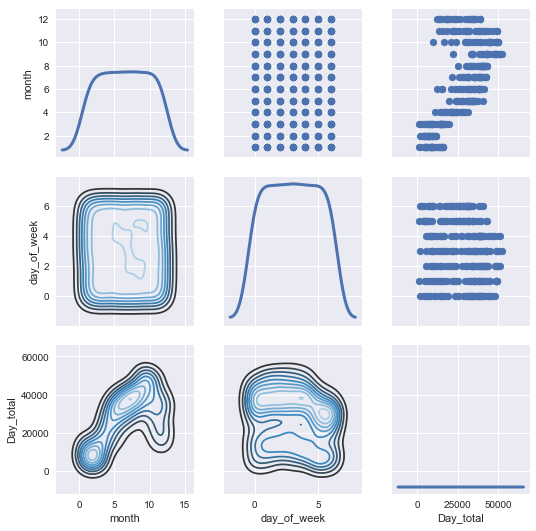

In [36]:
g = sns.PairGrid(trip_data_model_f1)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False);

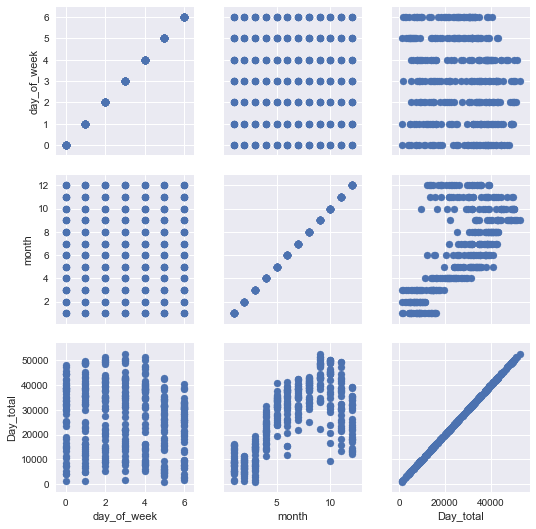

In [212]:
g = sns.PairGrid(trip_data_model_f1)
g.map(plt.scatter);

In [40]:
weather_df= pd.read_excel('/Users/torrie/Documents/Metis_Take_Home/NY_weather.xlsx', skiprows=None) 

In [41]:
weather_df = weather_df.rename(columns = {'high hind':'wind max', 'Unnamed: 8':'Events', 'sum':'Precip(in)', 'Date':'date'})

In [44]:
weather_df = weather_df[weather_df['Day'] != 2015]
date_range = range(32)
weather_df = weather_df[weather_df['Day'].isin(date_range)]
weather_df = weather_df.drop(['wind max','gusts','Events','high Temp', 'temp low','Events'], axis = 1)
weather_df.head()

,Day,temp avg,avg wind,Precip(in),date
0,1,34,17,0,2015-01-01
1,2,40,14,0,2015-01-02
2,3,39,9,0.94,2015-01-03
3,4,49,10,0.47,2015-01-04
4,5,37,20,0,2015-01-05


In [45]:
weather_df['date'] = pd.to_datetime(weather_df["date"], infer_datetime_format=False)

In [46]:
weather_df['Precip(in)'] = weather_df['Precip(in)'].replace('T',0.01)

In [48]:
trip_data_model_f1['date'] = pd.to_datetime(trip_data_model_f1['date'])

In [51]:
all_data = pd.merge(weather_df, trip_data_model_f1, on = 'date')

In [52]:
all_data = all_data.drop(['date','Day'], axis = 1)
all_data.head()

,temp avg,avg wind,Precip(in),month,day_of_week,Day_total
0,34,17,0.00,1,3,5317
1,40,14,0.00,1,4,11304
2,39,9,0.94,1,5,4478
3,49,10,0.47,1,6,7849
4,37,20,0.00,1,0,14506


In [58]:
print(all_data.describe())

         temp avg    avg wind  Precip(in)       month  day_of_week  \
count  365.000000  365.000000  365.000000  365.000000        365.0   
mean    56.389041   10.920548    0.105753    6.526027          3.0   
std     18.268657    4.060902    0.296736    3.452584          2.0   
min     12.000000    2.000000    0.000000    1.000000          0.0   
25%     43.000000    8.000000    0.000000    4.000000          1.0   
50%     58.000000   10.000000    0.000000    7.000000          3.0   
75%     73.000000   13.000000    0.020000   10.000000          5.0   
max     87.000000   28.000000    2.480000   12.000000          6.0   

          Day_total  
count    365.000000  
mean   27227.312329  
std    13470.980912  
min     1107.000000  
25%    15234.000000  
50%    30295.000000  
75%    38285.000000  
max    52706.000000  


### 1) Check for multicolinearity  
If a high degree of multicollinearity exists, either  
a) Use a method that handles collinearity  
b) Remove collinear features  
c) Transform features

In [59]:
#Print the pearson's correlation coefficient for each of the features

print(all_data.corr())

             temp avg  avg wind  Precip(in)     month  day_of_week  Day_total
temp avg     1.000000 -0.332309   -0.017381  0.494853    -0.017068   0.785300
avg wind    -0.332309  1.000000    0.032549 -0.268393    -0.019957  -0.345205
Precip(in)  -0.017381  0.032549    1.000000 -0.012777    -0.014767  -0.244702
month        0.494853 -0.268393   -0.012777  1.000000    -0.009549   0.660832
day_of_week -0.017068 -0.019957   -0.014767 -0.009549     1.000000  -0.172432
Day_total    0.785300 -0.345205   -0.244702  0.660832    -0.172432   1.000000


In [60]:
print(all_data.cov())

                  temp avg      avg wind  Precip(in)         month  \
temp avg        333.743836    -24.653071   -0.094222     31.212374   
avg wind        -24.653071     16.490923    0.039222     -3.763036   
Precip(in)       -0.094222      0.039222    0.088052     -0.013090   
month            31.212374     -3.763036   -0.013090     11.920337   
day_of_week      -0.623626     -0.162088   -0.008764     -0.065934   
Day_total    193259.856179 -18884.222369 -978.150346  30735.098991   

             day_of_week     Day_total  
temp avg       -0.623626  1.932599e+05  
avg wind       -0.162088 -1.888422e+04  
Precip(in)     -0.008764 -9.781503e+02  
month          -0.065934  3.073510e+04  
day_of_week     4.000000 -4.645662e+03  
Day_total   -4645.662088  1.814673e+08  


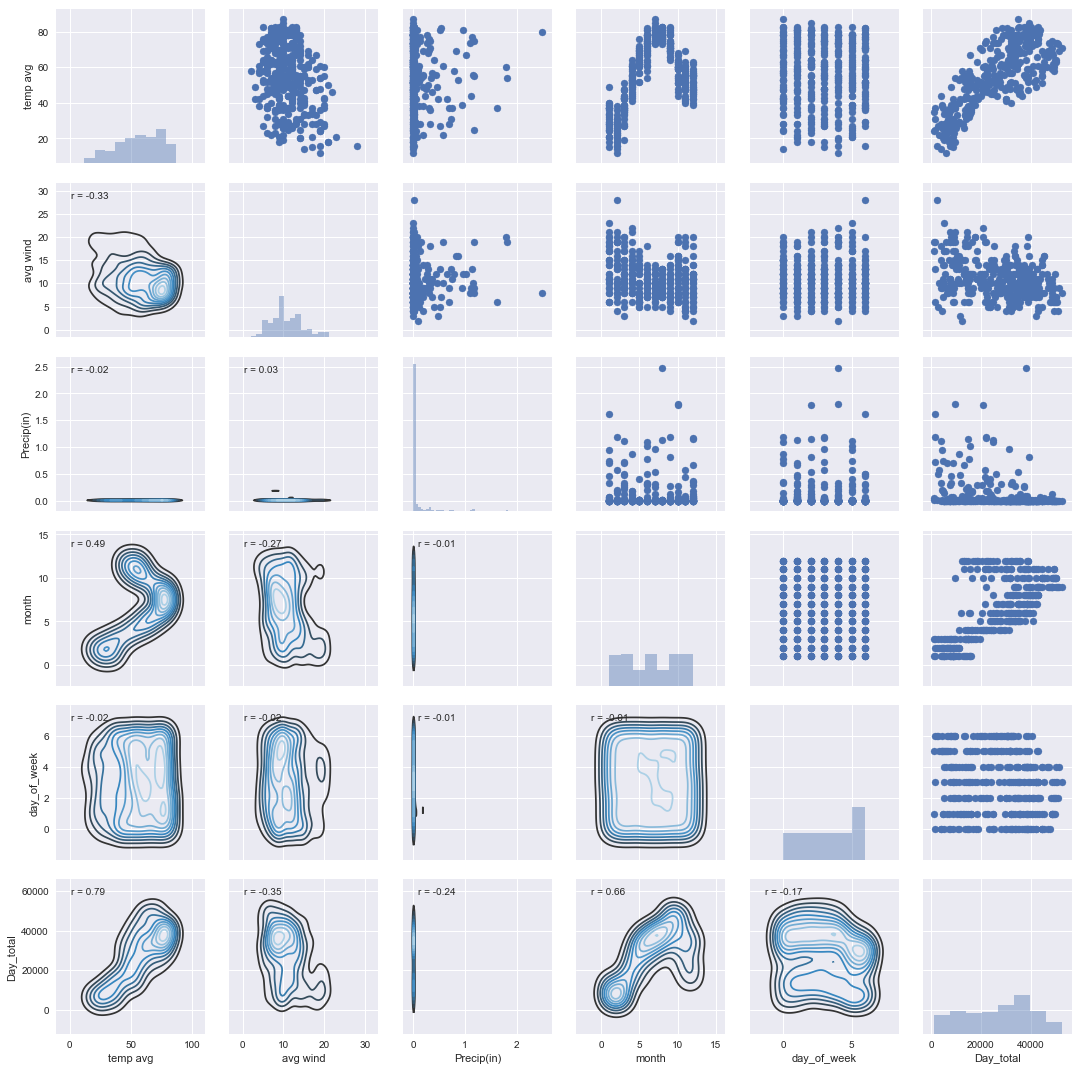

In [57]:
# Make a pairplot with scatterplots, histograms, and a density plot for each variables. 
# This helps us see what the data distribution is like and what our distributions look like
#Correlation coefficients are also printed on each plot
# The info can be used to determine if features need to be transformed and identify collinear features

from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(all_data)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.distplot, kde=False)
g.map_lower(corrfunc);

The month and the average temperature look to be correlated, so I will test with both variables and with only average temperature.

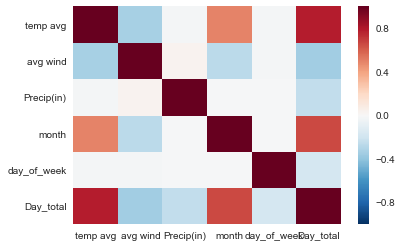

In [54]:
sns.heatmap(all_data.corr());


From the heatmap it is clear that the average temperature and the total daily riders are strongly correlated. 

### Check the distribution of the target variable(s)  



In [279]:
X = all_data.drop(['Day_total'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=4)

# Create your model
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Day_total   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     805.9
Date:                Mon, 07 Aug 2017   Prob (F-statistic):          2.30e-147
Time:                        21:50:24   Log-Likelihood:                -2518.9
No. Observations:                 244   AIC:                             5048.
Df Residuals:                     239   BIC:                             5065.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          4.048e+04   1670.871     24.228      0.000      3.72e+04  4.38e+04
x2         -2.013e+04   2537.509     -7.934      0.000     -2.51e+04 -1.51e+04
x3         -6.181e+05   1.04e+05     -5.941      0.000     -8.23e+05 -4.13e+05
x4         -9.346e+04   1.23e+04     -7.579      0.000     -1.18e+05 -6.92e+04
x5          5.009e+04   9377.697      5.342      0.000      3.16e+04  6.86e+04
==============================================================================
Omnibus:                        5.621   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.291
Skew:                          -0.330   Prob(JB):                       0.0710
Kurtosis:                       3.291   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [291]:
lr = LinearRegression()

# Fit the model to the train dataset
fit = lr.fit(X_train, y_train)

# Print out the R^2 for the model against the test dataset
print("Test:", lr.score(X_test,y_test))

Test: 0.650246748831


That is much better! 

In [456]:
X = all_data.drop(['Day_total','month'], axis =1)
y = all_data['Day_total']
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=4)

# Create your model
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Day_total   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     910.2
Date:                Tue, 08 Aug 2017   Prob (F-statistic):          1.02e-143
Time:                        10:31:37   Log-Likelihood:                -2531.1
No. Observations:                 244   AIC:                             5070.
Df Residuals:                     240   BIC:                             5084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            4.7e+04   1111.461     42.283      0.000      4.48e+04  4.92e+04
x2          -2.22e+04   2613.348     -8.494      0.000     -2.73e+04  -1.7e+04
x3         -6.607e+05   1.08e+05     -6.100      0.000     -8.74e+05 -4.47e+05
x4         -9.472e+04   1.29e+04     -7.368      0.000      -1.2e+05 -6.94e+04
==============================================================================
Omnibus:                        0.209   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.323
Skew:                          -0.056   Prob(JB):                        0.851
Kurtosis:                       2.862   Cond. No.                         212.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [457]:
lr = LinearRegression()

# Fit the model to the train dataset
fit = lr.fit(X_train, y_train)

# Print out the R^2 for the model against the test dataset
print("Test:", lr.score(X_test,y_test))

Test: 0.632197534121


Taking out month as a predictor decreased the test score, so I would choose the model with it left in.

## Question 6
• Using the tool of your preference, develop a visualization that displays something interesting about the data.

I'd like to show a map with the stations that have the highest number of bikes removed and the stations with the highest number of bikes added so I can visualize where people are starting their bike trips and ending them. 